In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import os
from skimage import io
import tensorflow as tf
import keras
from keras import backend as K 
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.layers import GlobalMaxPooling2D, Dense, Conv2D, Activation, BatchNormalization, Dropout,Concatenate, Input, MaxPooling2D, GlobalMaxPool2D, Lambda
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import cv2
from skimage.util import view_as_windows 
from scipy.io import loadmat
from scipy.stats import pearsonr, spearmanr
import xgboost as xgb

In [ ]:
!unzip /content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID.zip

In [4]:
!cp /content/PEID/refimg/* /content/PEID/encimg/

In [5]:
len(os.listdir('/content/PEID/encimg/'))

1100

In [6]:
peid =pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEIDDATASET.csv')

In [7]:
peid

,encrypted_image,reference_image,ground_truth,visual_quality
0,airport.bmp,airport.bmp,1.00,6.000000
1,airport_01_1.j2k,airport.bmp,0.20,0.142857
2,airport_01_2.j2k,airport.bmp,0.20,0.190476
3,airport_01_3.j2k,airport.bmp,0.20,0.714286
4,airport_01_4.j2k,airport.bmp,0.23,1.857143
...,...,...,...,...
1095,water_10_2.bmp,water.bmp,0.20,0.809524
1096,water_10_3.bmp,water.bmp,0.22,1.238095
1097,water_10_4.bmp,water.bmp,0.26,2.142857
1098,water_10_5.bmp,water.bmp,0.27,2.095238


In [8]:
train_visual = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID_train_file_visual.csv')
train_visual.head()

,encrypted_image,reference_image,visual_quality
0,airport.bmp,airport.bmp,1.000000
1,airport_01_1.j2k,airport.bmp,0.023810
2,airport_01_2.j2k,airport.bmp,0.031746
3,airport_01_3.j2k,airport.bmp,0.119048
4,airport_01_5.j2k,airport.bmp,0.547619


In [9]:
PEID_train_file = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID_train_file.csv')

In [10]:
PEID_train_file.head()

,encrypted_image,reference_image,ground_truth
0,airport.bmp,airport.bmp,1.00
1,airport_01_1.j2k,airport.bmp,0.20
2,airport_01_2.j2k,airport.bmp,0.20
3,airport_01_3.j2k,airport.bmp,0.20
4,airport_01_5.j2k,airport.bmp,0.31


In [11]:
testiq = pd.read_csv('/content/drive/MyDrive/Projet-5-em/Project-kadid10k/PEID_IQ_test_file.csv')

In [12]:
testiq.head()

,encrypted_image,reference_image,ground_truth
0,airport_01_4.j2k,airport.bmp,0.23
1,airport_02_6.jpg,airport.bmp,0.46
2,airport_04_5.j2k,airport.bmp,0.44
3,airport_06_2.j2k,airport.bmp,0.24
4,airport_07_3.bmp,airport.bmp,0.29


In [13]:
img = io.imread('/content/PEID/refimg/'+peid['reference_image'][0])
img1 = io.imread('/content/PEID/encimg/'+peid['encrypted_image'][1])
img2 = io.imread('/content/PEID/encimg/'+peid['encrypted_image'][2])

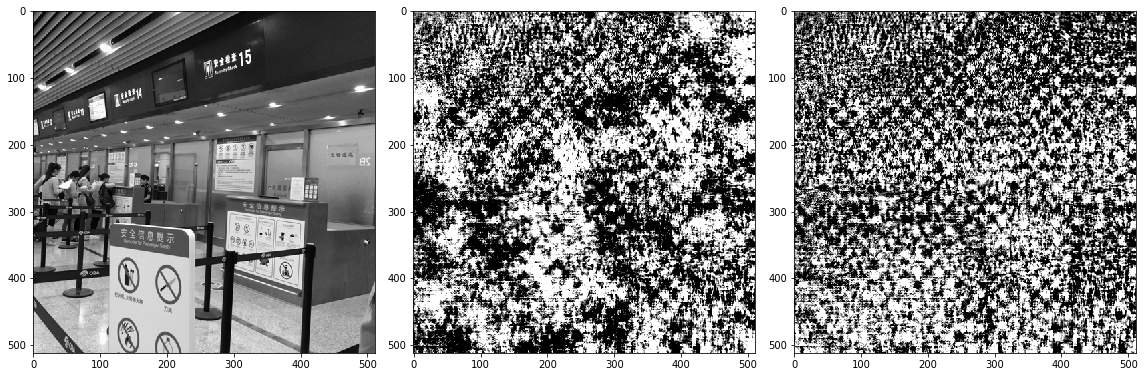

In [14]:
plt.figure(figsize=(16,16))

plt.subplot(1,3,1)
io.imshow(img)

plt.subplot(1,3,2)
io.imshow(img1)

plt.subplot(1,3,3)
io.imshow(img2)

In [15]:
def siamese_network(input_shape):
  model_input = Input(input_shape)

  x = Conv2D(32, kernel_size=(3,3), input_shape= input_shape, kernel_initializer='normal')(model_input)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x) 

  x = Conv2D(64, kernel_size=(3,3),  kernel_initializer='normal')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(128, kernel_size=(3,3),  kernel_initializer='normal')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  x = Conv2D(256, kernel_size=(3,3),  kernel_initializer='normal')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D()(x)

  model = Model(model_input, x)

  return model

In [16]:
imageA = Input((256, 256, 3))
imageB = Input((256, 256, 3))

caracExtractor = siamese_network((256, 256, 3))

caracExtractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 activation (Activation)     (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 activation_1 (Activation)   (None, 125, 125, 64)      0         
                                                             

In [17]:
def train_generator(batch_size):

  while True:
    for pos in range(0, len(PEID_train_file), batch_size):
      temp = PEID_train_file.iloc[pos:pos + batch_size] 
      
      encrypted_batch, reference_batch = [], []
      y_batch = []

      for encimg, refimg,y_train in zip(temp.encrypted_image, temp.reference_image, temp.ground_truth):
        encrypted_image = image.load_img('/content/PEID/encimg/'+encimg)
        reference_image = image.load_img('/content/PEID/refimg/'+refimg)
            
        encrypted_image = np.array(encrypted_image)
        reference_image = np.array(reference_image) 

        patches1 = view_as_windows(encrypted_image,(256, 256, 3),(256, 256, 3)).reshape((-1,256,256,3))  
        patches2 = view_as_windows(reference_image,(256, 256, 3),(256, 256, 3)).reshape((-1,256,256,3))  
            

        patches1 = patches1/ 255.0
        patches2 = patches2/ 255.0
        for i in range(4):
          encrypted_batch.append(patches1[i])
          reference_batch.append(patches2[i])
          y_batch.append(y_train)

      encrypted_batch = np.array(encrypted_batch)
      reference_batch = np.array(reference_batch)
      y_batch = np.array(y_batch)


      yield ([encrypted_batch, reference_batch], y_batch)

In [18]:
distance = Lambda( lambda vectors: K.abs(vectors[0] - vectors[1]))

In [19]:
featsA = caracExtractor(imageA)
featsB = caracExtractor(imageB)

In [20]:
encodingVector = Concatenate(name='concatenate')([featsA, featsB, distance([featsA, featsB])])  
average = GlobalMaxPooling2D()(encodingVector)
layer = Dense(512, kernel_initializer='normal')(average)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

layer = Dense(512, kernel_initializer='normal')(layer)
layer = BatchNormalization()(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.2)(layer)

outputs = Dense(1)(layer)

model = Model(inputs=[imageA, imageB], outputs=outputs)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 14, 14, 256)  388416      ['input_1[0][0]',                
                                                                  'input_2[0][0]']          

In [22]:
model.compile(loss="mae", optimizer=tf.optimizers.Adam())

print("[INFO] training model...")
callbak = [tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience= 50,
    mode = 'auto',
    min_delta=1e-5,
    restore_best_weights = True,
    verbose =1
)]
history = model.fit(
    train_generator(16),
    steps_per_epoch= len(PEID_train_file) // 16,
    epochs= 500,
    callbacks = callbak
  )

[INFO] training model...
Epoch 1/500
55/55 [==============================] - 49s 613ms/step - loss: 0.6050
Epoch 2/500
55/55 [==============================] - 34s 620ms/step - loss: 0.4270
Epoch 3/500
55/55 [==============================] - 34s 625ms/step - loss: 0.3158
Epoch 4/500
55/55 [==============================] - 35s 631ms/step - loss: 0.3059
Epoch 5/500
55/55 [==============================] - 34s 623ms/step - loss: 0.2561
Epoch 6/500
55/55 [==============================] - 34s 624ms/step - loss: 0.2375
Epoch 7/500
55/55 [==============================] - 34s 622ms/step - loss: 0.2149
Epoch 8/500
55/55 [==============================] - 34s 623ms/step - loss: 0.1945
Epoch 9/500
55/55 [==============================] - 34s 621ms/step - loss: 0.1794
Epoch 10/500
55/55 [==============================] - 34s 623ms/step - loss: 0.1519
Epoch 11/500
55/55 [==============================] - 34s 621ms/step - loss: 0.1437
Epoch 12/500
55/55 [==============================] - 35s 63

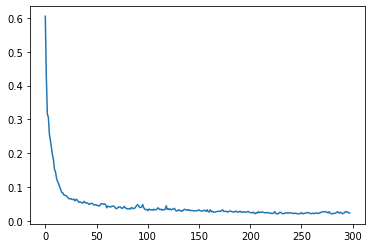

In [23]:
plt.plot(history.history['loss'])

In [24]:
y = []
for pos in range(0, len(testiq), 1):
  temp = testiq.iloc[pos:pos + 1] 
      
  encrypted_batch, reference_batch = [], []


  for encimg, refimg in zip(temp.encrypted_image, temp.reference_image):
    encrypted_image = image.load_img('/content/PEID/encimg/'+encimg)
    reference_image = image.load_img('/content/PEID/refimg/'+refimg)
            
    encrypted_image = np.array(encrypted_image)
    reference_image = np.array(reference_image) 

    patches1 = view_as_windows(encrypted_image,(256, 256, 3),(256, 256, 3)).reshape((-1,256,256,3))  
    patches2 = view_as_windows(reference_image,(256, 256, 3),(256, 256, 3)).reshape((-1,256,256,3))  

    patches1 = patches1/ 255.0
    patches2 = patches2/ 255.0

    for i in range(4):
      encrypted_batch = np.expand_dims(patches1[i], axis=0)
      reference_batch = np.expand_dims(patches2[i], axis=0)
      
      y.append(model.predict([encrypted_batch, reference_batch]))

In [25]:
ypred = []
for elt in y:
  ypred.append(elt[0][0])

ypred = np.array(ypred)
ypred.shape

(880,)

In [26]:
def chart_regression(pred, y, sort=True):
    t = pd.DataFrame({'pred': pred, 'y': y})
    if sort:
        t.sort_values(by=['y'], inplace=True)
    plt.plot(t['y'].tolist(), label='expected')
    plt.plot(t['pred'].tolist(), label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

In [27]:
dmos = []
somme, j = 0, 1
for elt in ypred:
  somme += elt
  if j >= 4:
    dmos.append(somme/4)
    j = 0
    somme = 0
  j = j+1

dmos = np.array(dmos)
dmos.shape

(220,)

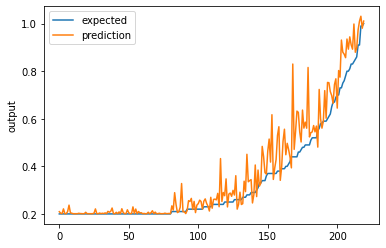

SpearmanrResult(correlation=0.9491862452618334, pvalue=1.99811151892517e-111)
PearsonrResult (0.9691769275031845, 1.2888306887935181e-134)


In [28]:
chart_regression(dmos, testiq['ground_truth'].values)
print(spearmanr(testiq['ground_truth'].values, dmos))
print('PearsonrResult',pearsonr(testiq['ground_truth'].values, dmos))

In [29]:
model.save('./VisualQuality.h5')

In [30]:
iq = {
    'ground_truth':testiq['ground_truth'].values,
    'predict_value':dmos
}
visualQ = pd.DataFrame(iq, columns=['ground_truth','predict_value'])
visualQ.to_csv('./VisualQualityScore.csv', index= False)